In [1]:
from datasets import load_dataset
ner_dataset = load_dataset(
    "tner/bc5cdr", 
)

print(f'The dataset is a dictionary with {len(ner_dataset)} splits: \n\n{ner_dataset}')


/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5865
    })
})


In [24]:
from datasets import load_dataset
ner_dataset = load_dataset("tner/bc5cdr", split='validation')  
print("first sample:", ner_dataset[0])
print("Dataset key:", ner_dataset.features.keys())

first sample: {'tokens': ['Tricuspid', 'valve', 'regurgitation', 'and', 'lithium', 'carbonate', 'toxicity', 'in', 'a', 'newborn', 'infant', '.'], 'tags': [2, 3, 3, 0, 1, 4, 2, 0, 0, 0, 0, 0]}
Dataset key: dict_keys(['tokens', 'tags'])


In [2]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
label_list = ["O", "B-Chemical", "I-Chemical", "B-Disease", "I-Disease"]

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128)
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  
            elif word_idx != previous_word_idx:
                label_ids.append(label_list.index("B-Chemical") if label[word_idx] == 1 else label_list.index("O"))
            else:
                label_ids.append(label_list.index("I-Chemical") if label[word_idx] == 1 else label_list.index("O"))
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

train_dataset = ner_dataset["train"].map(tokenize_and_align_labels, batched=True)
validation_dataset = ner_dataset["validation"].map(tokenize_and_align_labels, batched=True)
test_dataset = ner_dataset["test"].map(tokenize_and_align_labels, batched=True)

model_save_path = "./saved_model"
tokenizer.save_pretrained(model_save_path)


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [3]:
import sys
import torch
print("Python EXE:", sys.executable)
print("PyTorch version:", torch.__version__)

from transformers import BertForTokenClassification


Python EXE: /Users/leichen/anaconda3/envs/tf_env/bin/python
PyTorch version: 2.3.0


In [4]:
from transformers import BertForTokenClassification

print("BertForTokenClassification successfully imported.")
import transformers
print("Transformers version:", transformers.__version__)


BertForTokenClassification successfully imported.
Transformers version: 4.40.2


In [5]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments

model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(label_list))

training_args = TrainingArguments(
    output_dir="./results",  
    num_train_epochs=3,      # Number of training rounds
    per_device_train_batch_size=16,   # Training batch size per device.
    per_device_eval_batch_size=64,    # Evaluation batch size per device.
    warmup_steps=500,        # warm-up step
    weight_decay=0.01,       # weight decay
    logging_dir="./logs",    
    logging_steps=10         # Logging steps
)

# initial 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

trainer.train()
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print("Evaluation Results:", eval_results)
model_save_path = "./saved_model"
trainer.save_model(model_save_path)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 10/981 [00:14<21:47,  1.35s/it]

{'loss': 1.5754, 'grad_norm': 8.275425910949707, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


  2%|▏         | 20/981 [00:27<20:22,  1.27s/it]

{'loss': 1.4758, 'grad_norm': 7.506373882293701, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


  3%|▎         | 30/981 [00:41<22:59,  1.45s/it]

{'loss': 1.2588, 'grad_norm': 6.628764629364014, 'learning_rate': 3e-06, 'epoch': 0.09}


  4%|▍         | 40/981 [00:57<28:45,  1.83s/it]

{'loss': 0.946, 'grad_norm': 5.663846015930176, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.12}


  5%|▌         | 50/981 [01:13<21:37,  1.39s/it]

{'loss': 0.6349, 'grad_norm': 3.3117592334747314, 'learning_rate': 5e-06, 'epoch': 0.15}


  6%|▌         | 60/981 [01:26<19:38,  1.28s/it]

{'loss': 0.4488, 'grad_norm': 2.0391218662261963, 'learning_rate': 6e-06, 'epoch': 0.18}


  7%|▋         | 70/981 [01:38<19:20,  1.27s/it]

{'loss': 0.2614, 'grad_norm': 1.7059612274169922, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.21}


  8%|▊         | 80/981 [01:51<19:20,  1.29s/it]

{'loss': 0.211, 'grad_norm': 1.7881312370300293, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.24}


  9%|▉         | 90/981 [02:04<18:36,  1.25s/it]

{'loss': 0.1743, 'grad_norm': 1.6031360626220703, 'learning_rate': 9e-06, 'epoch': 0.28}


 10%|█         | 100/981 [02:16<18:22,  1.25s/it]

{'loss': 0.1793, 'grad_norm': 1.7934150695800781, 'learning_rate': 1e-05, 'epoch': 0.31}


 11%|█         | 110/981 [02:30<18:40,  1.29s/it]

{'loss': 0.1225, 'grad_norm': 0.9391013979911804, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.34}


 12%|█▏        | 120/981 [02:42<18:21,  1.28s/it]

{'loss': 0.1015, 'grad_norm': 0.8231440782546997, 'learning_rate': 1.2e-05, 'epoch': 0.37}


 13%|█▎        | 130/981 [02:55<19:10,  1.35s/it]

{'loss': 0.128, 'grad_norm': 1.9456955194473267, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.4}


 14%|█▍        | 140/981 [03:09<17:58,  1.28s/it]

{'loss': 0.0995, 'grad_norm': 1.3679149150848389, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.43}


 15%|█▌        | 150/981 [03:21<17:31,  1.27s/it]

{'loss': 0.0708, 'grad_norm': 1.1476482152938843, 'learning_rate': 1.5e-05, 'epoch': 0.46}


 16%|█▋        | 160/981 [03:35<17:42,  1.29s/it]

{'loss': 0.0744, 'grad_norm': 2.8250765800476074, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.49}


 17%|█▋        | 170/981 [03:48<17:21,  1.28s/it]

{'loss': 0.0658, 'grad_norm': 1.0833661556243896, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.52}


 18%|█▊        | 180/981 [04:01<17:12,  1.29s/it]

{'loss': 0.0384, 'grad_norm': 2.4527218341827393, 'learning_rate': 1.8e-05, 'epoch': 0.55}


 19%|█▉        | 190/981 [04:13<16:56,  1.29s/it]

{'loss': 0.0713, 'grad_norm': 3.6978919506073, 'learning_rate': 1.9e-05, 'epoch': 0.58}


 20%|██        | 200/981 [04:26<16:26,  1.26s/it]

{'loss': 0.0691, 'grad_norm': 2.130633592605591, 'learning_rate': 2e-05, 'epoch': 0.61}


 21%|██▏       | 210/981 [04:39<16:20,  1.27s/it]

{'loss': 0.1041, 'grad_norm': 0.8910413980484009, 'learning_rate': 2.1e-05, 'epoch': 0.64}


 22%|██▏       | 220/981 [04:51<16:11,  1.28s/it]

{'loss': 0.0667, 'grad_norm': 0.6992818117141724, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.67}


 23%|██▎       | 230/981 [05:04<15:24,  1.23s/it]

{'loss': 0.06, 'grad_norm': 1.405362844467163, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.7}


 24%|██▍       | 240/981 [05:17<15:29,  1.25s/it]

{'loss': 0.0568, 'grad_norm': 1.930396318435669, 'learning_rate': 2.4e-05, 'epoch': 0.73}


 25%|██▌       | 250/981 [05:30<16:27,  1.35s/it]

{'loss': 0.0606, 'grad_norm': 0.648204505443573, 'learning_rate': 2.5e-05, 'epoch': 0.76}


 27%|██▋       | 260/981 [05:43<15:05,  1.26s/it]

{'loss': 0.0632, 'grad_norm': 4.942562103271484, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.8}


 28%|██▊       | 270/981 [05:55<15:15,  1.29s/it]

{'loss': 0.0401, 'grad_norm': 1.7140114307403564, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.83}


 29%|██▊       | 280/981 [06:08<14:52,  1.27s/it]

{'loss': 0.0578, 'grad_norm': 1.3099778890609741, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.86}


 30%|██▉       | 290/981 [06:21<14:42,  1.28s/it]

{'loss': 0.0456, 'grad_norm': 0.9325704574584961, 'learning_rate': 2.9e-05, 'epoch': 0.89}


 31%|███       | 300/981 [06:35<15:17,  1.35s/it]

{'loss': 0.0482, 'grad_norm': 4.132783889770508, 'learning_rate': 3e-05, 'epoch': 0.92}


 32%|███▏      | 310/981 [06:48<14:15,  1.27s/it]

{'loss': 0.0555, 'grad_norm': 0.7026405334472656, 'learning_rate': 3.1e-05, 'epoch': 0.95}


 33%|███▎      | 320/981 [07:01<14:11,  1.29s/it]

{'loss': 0.0451, 'grad_norm': 1.378600001335144, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.98}


 34%|███▎      | 330/981 [07:13<13:31,  1.25s/it]

{'loss': 0.0359, 'grad_norm': 2.101466655731201, 'learning_rate': 3.3e-05, 'epoch': 1.01}


 35%|███▍      | 340/981 [07:26<13:44,  1.29s/it]

{'loss': 0.0294, 'grad_norm': 0.7154428362846375, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.04}


 36%|███▌      | 350/981 [07:40<13:28,  1.28s/it]

{'loss': 0.022, 'grad_norm': 0.8879937529563904, 'learning_rate': 3.5e-05, 'epoch': 1.07}


 37%|███▋      | 360/981 [07:52<12:47,  1.24s/it]

{'loss': 0.0252, 'grad_norm': 1.4393885135650635, 'learning_rate': 3.6e-05, 'epoch': 1.1}


 38%|███▊      | 370/981 [08:06<13:25,  1.32s/it]

{'loss': 0.0659, 'grad_norm': 3.9147891998291016, 'learning_rate': 3.7e-05, 'epoch': 1.13}


 39%|███▊      | 380/981 [08:18<12:55,  1.29s/it]

{'loss': 0.0485, 'grad_norm': 2.8896541595458984, 'learning_rate': 3.8e-05, 'epoch': 1.16}


 40%|███▉      | 390/981 [08:31<12:52,  1.31s/it]

{'loss': 0.0252, 'grad_norm': 0.4911821782588959, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.19}


 41%|████      | 400/981 [08:44<12:20,  1.27s/it]

{'loss': 0.0275, 'grad_norm': 1.0778577327728271, 'learning_rate': 4e-05, 'epoch': 1.22}


 42%|████▏     | 410/981 [08:57<12:13,  1.29s/it]

{'loss': 0.0339, 'grad_norm': 1.8956499099731445, 'learning_rate': 4.1e-05, 'epoch': 1.25}


 43%|████▎     | 420/981 [09:10<12:30,  1.34s/it]

{'loss': 0.0368, 'grad_norm': 1.8229924440383911, 'learning_rate': 4.2e-05, 'epoch': 1.28}


 44%|████▍     | 430/981 [09:23<11:29,  1.25s/it]

{'loss': 0.034, 'grad_norm': 1.1971306800842285, 'learning_rate': 4.3e-05, 'epoch': 1.31}


 45%|████▍     | 440/981 [09:36<11:31,  1.28s/it]

{'loss': 0.0439, 'grad_norm': 0.7725909948348999, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.35}


 46%|████▌     | 450/981 [09:48<11:05,  1.25s/it]

{'loss': 0.0223, 'grad_norm': 5.261417865753174, 'learning_rate': 4.5e-05, 'epoch': 1.38}


 47%|████▋     | 460/981 [10:02<11:37,  1.34s/it]

{'loss': 0.0407, 'grad_norm': 1.3101680278778076, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.41}


 48%|████▊     | 470/981 [10:15<11:19,  1.33s/it]

{'loss': 0.0167, 'grad_norm': 0.3305816650390625, 'learning_rate': 4.7e-05, 'epoch': 1.44}


 49%|████▉     | 480/981 [10:28<11:01,  1.32s/it]

{'loss': 0.0278, 'grad_norm': 0.21529822051525116, 'learning_rate': 4.8e-05, 'epoch': 1.47}


 50%|████▉     | 490/981 [10:41<10:34,  1.29s/it]

{'loss': 0.0229, 'grad_norm': 1.1246691942214966, 'learning_rate': 4.9e-05, 'epoch': 1.5}


 51%|█████     | 500/981 [10:54<10:11,  1.27s/it]

{'loss': 0.0256, 'grad_norm': 4.025320529937744, 'learning_rate': 5e-05, 'epoch': 1.53}


 52%|█████▏    | 510/981 [11:09<10:07,  1.29s/it]

{'loss': 0.0246, 'grad_norm': 5.586374759674072, 'learning_rate': 4.896049896049896e-05, 'epoch': 1.56}


 53%|█████▎    | 520/981 [11:22<09:46,  1.27s/it]

{'loss': 0.0149, 'grad_norm': 0.8040820360183716, 'learning_rate': 4.792099792099792e-05, 'epoch': 1.59}


 54%|█████▍    | 530/981 [11:35<09:39,  1.29s/it]

{'loss': 0.0324, 'grad_norm': 3.061063051223755, 'learning_rate': 4.6881496881496886e-05, 'epoch': 1.62}


 55%|█████▌    | 540/981 [11:48<09:44,  1.33s/it]

{'loss': 0.0227, 'grad_norm': 0.6869214177131653, 'learning_rate': 4.5841995841995844e-05, 'epoch': 1.65}


 56%|█████▌    | 550/981 [12:02<09:44,  1.36s/it]

{'loss': 0.0382, 'grad_norm': 1.7313109636306763, 'learning_rate': 4.48024948024948e-05, 'epoch': 1.68}


 57%|█████▋    | 560/981 [12:14<09:02,  1.29s/it]

{'loss': 0.0402, 'grad_norm': 3.4399633407592773, 'learning_rate': 4.376299376299376e-05, 'epoch': 1.71}


 58%|█████▊    | 570/981 [12:27<08:19,  1.21s/it]

{'loss': 0.034, 'grad_norm': 0.6311866641044617, 'learning_rate': 4.272349272349273e-05, 'epoch': 1.74}


 59%|█████▉    | 580/981 [12:40<08:29,  1.27s/it]

{'loss': 0.0166, 'grad_norm': 0.831609308719635, 'learning_rate': 4.1683991683991686e-05, 'epoch': 1.77}


 60%|██████    | 590/981 [12:53<08:15,  1.27s/it]

{'loss': 0.0433, 'grad_norm': 0.478711873292923, 'learning_rate': 4.0644490644490645e-05, 'epoch': 1.8}


 61%|██████    | 600/981 [13:06<08:06,  1.28s/it]

{'loss': 0.0376, 'grad_norm': 0.48357710242271423, 'learning_rate': 3.9604989604989604e-05, 'epoch': 1.83}


 62%|██████▏   | 610/981 [13:18<07:44,  1.25s/it]

{'loss': 0.0235, 'grad_norm': 0.8442620635032654, 'learning_rate': 3.856548856548857e-05, 'epoch': 1.87}


 63%|██████▎   | 620/981 [13:31<07:25,  1.24s/it]

{'loss': 0.0202, 'grad_norm': 1.168014645576477, 'learning_rate': 3.752598752598753e-05, 'epoch': 1.9}


 64%|██████▍   | 630/981 [13:43<07:20,  1.25s/it]

{'loss': 0.0331, 'grad_norm': 0.656255841255188, 'learning_rate': 3.648648648648649e-05, 'epoch': 1.93}


 65%|██████▌   | 640/981 [13:56<07:21,  1.29s/it]

{'loss': 0.0487, 'grad_norm': 1.5724143981933594, 'learning_rate': 3.5446985446985446e-05, 'epoch': 1.96}


 66%|██████▋   | 650/981 [14:09<07:08,  1.30s/it]

{'loss': 0.0355, 'grad_norm': 1.14259934425354, 'learning_rate': 3.4407484407484405e-05, 'epoch': 1.99}


 67%|██████▋   | 660/981 [14:22<06:39,  1.24s/it]

{'loss': 0.0112, 'grad_norm': 0.18405647575855255, 'learning_rate': 3.336798336798337e-05, 'epoch': 2.02}


 68%|██████▊   | 670/981 [14:34<06:21,  1.23s/it]

{'loss': 0.01, 'grad_norm': 2.326263666152954, 'learning_rate': 3.232848232848233e-05, 'epoch': 2.05}


 69%|██████▉   | 680/981 [14:47<06:17,  1.25s/it]

{'loss': 0.008, 'grad_norm': 0.1573597937822342, 'learning_rate': 3.128898128898129e-05, 'epoch': 2.08}


 70%|███████   | 690/981 [15:00<06:05,  1.26s/it]

{'loss': 0.0063, 'grad_norm': 0.021877920255064964, 'learning_rate': 3.024948024948025e-05, 'epoch': 2.11}


 71%|███████▏  | 700/981 [15:12<06:06,  1.30s/it]

{'loss': 0.0158, 'grad_norm': 3.1603922843933105, 'learning_rate': 2.920997920997921e-05, 'epoch': 2.14}


 72%|███████▏  | 710/981 [15:26<05:49,  1.29s/it]

{'loss': 0.0077, 'grad_norm': 1.3966158628463745, 'learning_rate': 2.817047817047817e-05, 'epoch': 2.17}


 73%|███████▎  | 720/981 [15:38<05:33,  1.28s/it]

{'loss': 0.0163, 'grad_norm': 0.01264768186956644, 'learning_rate': 2.713097713097713e-05, 'epoch': 2.2}


 74%|███████▍  | 730/981 [15:51<05:15,  1.26s/it]

{'loss': 0.0088, 'grad_norm': 0.33701515197753906, 'learning_rate': 2.6091476091476092e-05, 'epoch': 2.23}


 75%|███████▌  | 740/981 [16:04<05:06,  1.27s/it]

{'loss': 0.0329, 'grad_norm': 0.0702601745724678, 'learning_rate': 2.505197505197505e-05, 'epoch': 2.26}


 76%|███████▋  | 750/981 [16:17<04:58,  1.29s/it]

{'loss': 0.0087, 'grad_norm': 0.04948662966489792, 'learning_rate': 2.4012474012474013e-05, 'epoch': 2.29}


 77%|███████▋  | 760/981 [16:30<04:40,  1.27s/it]

{'loss': 0.0043, 'grad_norm': 0.2520616054534912, 'learning_rate': 2.2972972972972976e-05, 'epoch': 2.32}


 78%|███████▊  | 770/981 [16:43<04:35,  1.31s/it]

{'loss': 0.0106, 'grad_norm': 3.4615750312805176, 'learning_rate': 2.1933471933471934e-05, 'epoch': 2.35}


 80%|███████▉  | 780/981 [16:56<04:34,  1.36s/it]

{'loss': 0.0199, 'grad_norm': 0.6302343606948853, 'learning_rate': 2.0893970893970897e-05, 'epoch': 2.39}


 81%|████████  | 790/981 [17:10<04:08,  1.30s/it]

{'loss': 0.0119, 'grad_norm': 0.07974012196063995, 'learning_rate': 1.9854469854469855e-05, 'epoch': 2.42}


 82%|████████▏ | 800/981 [17:22<03:47,  1.26s/it]

{'loss': 0.0073, 'grad_norm': 0.14644470810890198, 'learning_rate': 1.8814968814968818e-05, 'epoch': 2.45}


 83%|████████▎ | 810/981 [17:35<03:31,  1.24s/it]

{'loss': 0.0182, 'grad_norm': 0.05904211848974228, 'learning_rate': 1.7775467775467776e-05, 'epoch': 2.48}


 84%|████████▎ | 820/981 [17:47<03:19,  1.24s/it]

{'loss': 0.0076, 'grad_norm': 1.6209686994552612, 'learning_rate': 1.673596673596674e-05, 'epoch': 2.51}


 85%|████████▍ | 830/981 [18:00<03:11,  1.27s/it]

{'loss': 0.0073, 'grad_norm': 0.013716140761971474, 'learning_rate': 1.5696465696465697e-05, 'epoch': 2.54}


 86%|████████▌ | 840/981 [18:12<02:57,  1.26s/it]

{'loss': 0.0059, 'grad_norm': 0.4806203246116638, 'learning_rate': 1.4656964656964658e-05, 'epoch': 2.57}


 87%|████████▋ | 850/981 [18:25<02:44,  1.26s/it]

{'loss': 0.0083, 'grad_norm': 0.23584091663360596, 'learning_rate': 1.3617463617463619e-05, 'epoch': 2.6}


 88%|████████▊ | 860/981 [18:38<02:33,  1.27s/it]

{'loss': 0.0327, 'grad_norm': 7.0953288078308105, 'learning_rate': 1.2577962577962579e-05, 'epoch': 2.63}


 89%|████████▊ | 870/981 [18:50<02:18,  1.25s/it]

{'loss': 0.0208, 'grad_norm': 1.5263912677764893, 'learning_rate': 1.153846153846154e-05, 'epoch': 2.66}


 90%|████████▉ | 880/981 [19:03<02:07,  1.26s/it]

{'loss': 0.0149, 'grad_norm': 2.2414636611938477, 'learning_rate': 1.04989604989605e-05, 'epoch': 2.69}


 91%|█████████ | 890/981 [19:16<01:56,  1.28s/it]

{'loss': 0.0084, 'grad_norm': 0.45339566469192505, 'learning_rate': 9.45945945945946e-06, 'epoch': 2.72}


 92%|█████████▏| 900/981 [19:29<01:45,  1.31s/it]

{'loss': 0.0108, 'grad_norm': 0.2237703800201416, 'learning_rate': 8.419958419958421e-06, 'epoch': 2.75}


 93%|█████████▎| 910/981 [19:41<01:27,  1.23s/it]

{'loss': 0.0083, 'grad_norm': 0.0803079605102539, 'learning_rate': 7.3804573804573816e-06, 'epoch': 2.78}


 94%|█████████▍| 920/981 [19:54<01:16,  1.25s/it]

{'loss': 0.0109, 'grad_norm': 0.010352611541748047, 'learning_rate': 6.340956340956341e-06, 'epoch': 2.81}


 95%|█████████▍| 930/981 [20:06<01:04,  1.26s/it]

{'loss': 0.0061, 'grad_norm': 2.760326385498047, 'learning_rate': 5.301455301455302e-06, 'epoch': 2.84}


 96%|█████████▌| 940/981 [20:19<00:51,  1.26s/it]

{'loss': 0.0164, 'grad_norm': 0.7287020683288574, 'learning_rate': 4.261954261954262e-06, 'epoch': 2.87}


 97%|█████████▋| 950/981 [20:32<00:39,  1.27s/it]

{'loss': 0.0075, 'grad_norm': 0.15007391571998596, 'learning_rate': 3.2224532224532228e-06, 'epoch': 2.91}


 98%|█████████▊| 960/981 [20:44<00:25,  1.23s/it]

{'loss': 0.0101, 'grad_norm': 0.013710582628846169, 'learning_rate': 2.1829521829521833e-06, 'epoch': 2.94}


 99%|█████████▉| 970/981 [20:57<00:14,  1.33s/it]

{'loss': 0.0085, 'grad_norm': 0.3740752935409546, 'learning_rate': 1.1434511434511436e-06, 'epoch': 2.97}


100%|█████████▉| 980/981 [21:11<00:01,  1.36s/it]

{'loss': 0.0052, 'grad_norm': 0.11190807819366455, 'learning_rate': 1.0395010395010396e-07, 'epoch': 3.0}


100%|██████████| 981/981 [21:12<00:00,  1.30s/it]


{'train_runtime': 1272.4444, 'train_samples_per_second': 12.326, 'train_steps_per_second': 0.771, 'train_loss': 0.10352206328517315, 'epoch': 3.0}


100%|██████████| 92/92 [01:59<00:00,  1.30s/it]


Evaluation Results: {'eval_loss': 0.06872030347585678, 'eval_runtime': 120.0949, 'eval_samples_per_second': 48.836, 'eval_steps_per_second': 0.766, 'epoch': 3.0}


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions, labels, _ = trainer.predict(test_dataset)

decoded_preds = np.argmax(predictions, axis=2)
decoded_labels = labels[labels != -100]
decoded_preds = decoded_preds[labels != -100]

# confusion matrix
conf_matrix = confusion_matrix(decoded_labels, decoded_preds, labels=list(range(len(label_list))))
print("Confusion Matrix:\n", conf_matrix)

# Identify misclassified indices.
misclassified_indices = np.where(decoded_preds != decoded_labels)[0]

for index in misclassified_indices[:10]:
    original_index = int(np.where(labels != -100)[0][index])
    token_ids = test_dataset[original_index]['input_ids']
    token = tokenizer.decode(token_ids)
    predicted_label = label_list[decoded_preds[index]]
    actual_label = label_list[decoded_labels[index]]
    print(f"Token: {token}, Predicted: {predicted_label}, Actual: {actual_label}")

100%|██████████| 92/92 [01:53<00:00,  1.23s/it]

Confusion Matrix:
 [[136057    444    989      0      0]
 [   433   4916     31      0      0]
 [   667     19  12199      0      0]
 [     0      0      0      0      0]
 [     0      0      0      0      0]]
Token: [CLS] famotidine is a histamine h2 - receptor antagonist used in inpatient settings for prevention of stress ulcers and is showing increasing popularity because of its low cost. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD], Predicted: B-Chemical, Actual: O
Token: [CLS] famotidine is a hi

  1%|▏         | 13/981 [02:20<2:54:19, 10.81s/it]

                                             

{'loss': 0.0061, 'grad_norm': 0.3586277961730957, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


{'loss': 0.0021, 'grad_norm': 0.11810613423585892, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


{'loss': 0.0073, 'grad_norm': 0.13009223341941833, 'learning_rate': 3e-06, 'epoch': 0.09}


{'loss': 0.0062, 'grad_norm': 0.35514184832572937, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.12}


{'loss': 0.0012, 'grad_norm': 0.0150094423443079, 'learning_rate': 5e-06, 'epoch': 0.15}


{'loss': 0.011, 'grad_norm': 0.11277608573436737, 'learning_rate': 6e-06, 'epoch': 0.18}


{'loss': 0.0093, 'grad_norm': 1.2054722309112549, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.21}


{'loss': 0.0115, 'grad_norm': 1.8312429189682007, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.24}


{'loss': 0.0073, 'grad_norm': 8.635798454284668, 'learning_rate': 9e-06, 'epoch': 0.28}


{'loss': 0.0084, 'grad_norm': 0.019833236932754517, 'learning_rate': 1e-05, 'epoch': 0.31}


{'loss': 0.0095, 'grad_norm': 0.27606505155563354, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.34}


{'loss': 0.003, 'grad_norm': 0.35633862018585205, 'learning_rate': 1.2e-05, 'epoch': 0.37}


{'loss': 0.0027, 'grad_norm': 0.344697505235672, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.4}


{'loss': 0.0015, 'grad_norm': 0.6470130085945129, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.43}


{'loss': 0.0028, 'grad_norm': 0.9698202610015869, 'learning_rate': 1.5e-05, 'epoch': 0.46}


{'loss': 0.0033, 'grad_norm': 0.43227678537368774, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.49}


{'loss': 0.0047, 'grad_norm': 0.01958928257226944, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.52}


{'loss': 0.0032, 'grad_norm': 3.6286261081695557, 'learning_rate': 1.8e-05, 'epoch': 0.55}


{'loss': 0.0041, 'grad_norm': 0.7031797170639038, 'learning_rate': 1.9e-05, 'epoch': 0.58}


{'loss': 0.0042, 'grad_norm': 0.7144234776496887, 'learning_rate': 2e-05, 'epoch': 0.61}


{'loss': 0.0315, 'grad_norm': 0.6414187550544739, 'learning_rate': 2.1e-05, 'epoch': 0.64}


{'loss': 0.0108, 'grad_norm': 0.3051125109195709, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.67}


{'loss': 0.0016, 'grad_norm': 0.018008962273597717, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.7}


{'loss': 0.0119, 'grad_norm': 0.5075491070747375, 'learning_rate': 2.4e-05, 'epoch': 0.73}


{'loss': 0.0009, 'grad_norm': 0.019087811931967735, 'learning_rate': 2.5e-05, 'epoch': 0.76}


{'loss': 0.0067, 'grad_norm': 0.46972203254699707, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.8}


{'loss': 0.0055, 'grad_norm': 1.9257832765579224, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.83}


{'loss': 0.0139, 'grad_norm': 1.9593290090560913, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.86}


{'loss': 0.004, 'grad_norm': 0.6881141662597656, 'learning_rate': 2.9e-05, 'epoch': 0.89}


{'loss': 0.0069, 'grad_norm': 2.114340305328369, 'learning_rate': 3e-05, 'epoch': 0.92}


{'loss': 0.0064, 'grad_norm': 0.057844407856464386, 'learning_rate': 3.1e-05, 'epoch': 0.95}


{'loss': 0.0028, 'grad_norm': 0.7111749649047852, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.98}


{'loss': 0.002, 'grad_norm': 1.0997213125228882, 'learning_rate': 3.3e-05, 'epoch': 1.01}


{'loss': 0.0046, 'grad_norm': 1.7831517457962036, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.04}


{'loss': 0.0016, 'grad_norm': 0.02094988338649273, 'learning_rate': 3.5e-05, 'epoch': 1.07}


{'loss': 0.0096, 'grad_norm': 0.3421139121055603, 'learning_rate': 3.6e-05, 'epoch': 1.1}


{'loss': 0.0137, 'grad_norm': 0.17349432408809662, 'learning_rate': 3.7e-05, 'epoch': 1.13}


{'loss': 0.0131, 'grad_norm': 0.5220810174942017, 'learning_rate': 3.8e-05, 'epoch': 1.16}


{'loss': 0.0049, 'grad_norm': 0.02557111717760563, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.19}


{'loss': 0.006, 'grad_norm': 0.4927203357219696, 'learning_rate': 4e-05, 'epoch': 1.22}


{'loss': 0.0088, 'grad_norm': 1.7894116640090942, 'learning_rate': 4.1e-05, 'epoch': 1.25}


{'loss': 0.0112, 'grad_norm': 0.1554890125989914, 'learning_rate': 4.2e-05, 'epoch': 1.28}


{'loss': 0.0045, 'grad_norm': 0.5345168113708496, 'learning_rate': 4.3e-05, 'epoch': 1.31}


{'loss': 0.0218, 'grad_norm': 0.32022687792778015, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.35}


{'loss': 0.009, 'grad_norm': 0.02149004116654396, 'learning_rate': 4.5e-05, 'epoch': 1.38}


{'loss': 0.0276, 'grad_norm': 0.23482155799865723, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.41}


{'loss': 0.009, 'grad_norm': 1.2322102785110474, 'learning_rate': 4.7e-05, 'epoch': 1.44}


{'loss': 0.0056, 'grad_norm': 0.006316309329122305, 'learning_rate': 4.8e-05, 'epoch': 1.47}


{'loss': 0.0025, 'grad_norm': 1.517507791519165, 'learning_rate': 4.9e-05, 'epoch': 1.5}


{'loss': 0.005, 'grad_norm': 0.7179620862007141, 'learning_rate': 5e-05, 'epoch': 1.53}


{'loss': 0.0028, 'grad_norm': 0.12250851094722748, 'learning_rate': 4.896049896049896e-05, 'epoch': 1.56}


{'loss': 0.0027, 'grad_norm': 0.31072837114334106, 'learning_rate': 4.792099792099792e-05, 'epoch': 1.59}


{'loss': 0.0088, 'grad_norm': 7.514142990112305, 'learning_rate': 4.6881496881496886e-05, 'epoch': 1.62}


{'loss': 0.0038, 'grad_norm': 0.011839429847896099, 'learning_rate': 4.5841995841995844e-05, 'epoch': 1.65}


{'loss': 0.0145, 'grad_norm': 0.007505560293793678, 'learning_rate': 4.48024948024948e-05, 'epoch': 1.68}


{'loss': 0.0148, 'grad_norm': 1.9496101140975952, 'learning_rate': 4.376299376299376e-05, 'epoch': 1.71}


{'loss': 0.0147, 'grad_norm': 0.2537717819213867, 'learning_rate': 4.272349272349273e-05, 'epoch': 1.74}


{'loss': 0.0115, 'grad_norm': 0.6730823516845703, 'learning_rate': 4.1683991683991686e-05, 'epoch': 1.77}


{'loss': 0.0158, 'grad_norm': 0.7555083632469177, 'learning_rate': 4.0644490644490645e-05, 'epoch': 1.8}


{'loss': 0.0158, 'grad_norm': 0.34670141339302063, 'learning_rate': 3.9604989604989604e-05, 'epoch': 1.83}


{'loss': 0.0147, 'grad_norm': 0.23150528967380524, 'learning_rate': 3.856548856548857e-05, 'epoch': 1.87}


{'loss': 0.0105, 'grad_norm': 0.016436316072940826, 'learning_rate': 3.752598752598753e-05, 'epoch': 1.9}


{'loss': 0.0102, 'grad_norm': 0.026821758598089218, 'learning_rate': 3.648648648648649e-05, 'epoch': 1.93}


{'loss': 0.0158, 'grad_norm': 1.1466975212097168, 'learning_rate': 3.5446985446985446e-05, 'epoch': 1.96}


{'loss': 0.0176, 'grad_norm': 1.5138813257217407, 'learning_rate': 3.4407484407484405e-05, 'epoch': 1.99}


{'loss': 0.0028, 'grad_norm': 0.039436765015125275, 'learning_rate': 3.336798336798337e-05, 'epoch': 2.02}


{'loss': 0.0067, 'grad_norm': 0.016548506915569305, 'learning_rate': 3.232848232848233e-05, 'epoch': 2.05}


{'loss': 0.0079, 'grad_norm': 0.35659435391426086, 'learning_rate': 3.128898128898129e-05, 'epoch': 2.08}


{'loss': 0.0013, 'grad_norm': 0.00552172027528286, 'learning_rate': 3.024948024948025e-05, 'epoch': 2.11}


{'loss': 0.0106, 'grad_norm': 0.061804983764886856, 'learning_rate': 2.920997920997921e-05, 'epoch': 2.14}


{'loss': 0.0018, 'grad_norm': 0.1517236828804016, 'learning_rate': 2.817047817047817e-05, 'epoch': 2.17}


{'loss': 0.0023, 'grad_norm': 0.03427613899111748, 'learning_rate': 2.713097713097713e-05, 'epoch': 2.2}


{'loss': 0.0007, 'grad_norm': 0.2257436364889145, 'learning_rate': 2.6091476091476092e-05, 'epoch': 2.23}


{'loss': 0.0195, 'grad_norm': 0.005889127030968666, 'learning_rate': 2.505197505197505e-05, 'epoch': 2.26}


{'loss': 0.0057, 'grad_norm': 0.019127877429127693, 'learning_rate': 2.4012474012474013e-05, 'epoch': 2.29}


{'loss': 0.0024, 'grad_norm': 0.011305251158773899, 'learning_rate': 2.2972972972972976e-05, 'epoch': 2.32}


{'loss': 0.0045, 'grad_norm': 0.8194541335105896, 'learning_rate': 2.1933471933471934e-05, 'epoch': 2.35}


{'loss': 0.0045, 'grad_norm': 0.11588571965694427, 'learning_rate': 2.0893970893970897e-05, 'epoch': 2.39}


{'loss': 0.0112, 'grad_norm': 0.13995471596717834, 'learning_rate': 1.9854469854469855e-05, 'epoch': 2.42}


{'loss': 0.0028, 'grad_norm': 0.9717962741851807, 'learning_rate': 1.8814968814968818e-05, 'epoch': 2.45}


{'loss': 0.0166, 'grad_norm': 0.16753365099430084, 'learning_rate': 1.7775467775467776e-05, 'epoch': 2.48}


{'loss': 0.0047, 'grad_norm': 0.05457634478807449, 'learning_rate': 1.673596673596674e-05, 'epoch': 2.51}


{'loss': 0.0026, 'grad_norm': 0.17478115856647491, 'learning_rate': 1.5696465696465697e-05, 'epoch': 2.54}


{'loss': 0.0008, 'grad_norm': 0.00923488475382328, 'learning_rate': 1.4656964656964658e-05, 'epoch': 2.57}


{'loss': 0.0044, 'grad_norm': 0.204840749502182, 'learning_rate': 1.3617463617463619e-05, 'epoch': 2.6}


{'loss': 0.0129, 'grad_norm': 7.14773416519165, 'learning_rate': 1.2577962577962579e-05, 'epoch': 2.63}


{'loss': 0.012, 'grad_norm': 0.8842071890830994, 'learning_rate': 1.153846153846154e-05, 'epoch': 2.66}


{'loss': 0.0011, 'grad_norm': 0.1886730045080185, 'learning_rate': 1.04989604989605e-05, 'epoch': 2.69}


{'loss': 0.0036, 'grad_norm': 0.04242056980729103, 'learning_rate': 9.45945945945946e-06, 'epoch': 2.72}


{'loss': 0.0046, 'grad_norm': 0.15303529798984528, 'learning_rate': 8.419958419958421e-06, 'epoch': 2.75}


{'loss': 0.0081, 'grad_norm': 0.15808457136154175, 'learning_rate': 7.3804573804573816e-06, 'epoch': 2.78}


{'loss': 0.0011, 'grad_norm': 0.005478412378579378, 'learning_rate': 6.340956340956341e-06, 'epoch': 2.81}


{'loss': 0.0045, 'grad_norm': 0.019575757905840874, 'learning_rate': 5.301455301455302e-06, 'epoch': 2.84}


{'loss': 0.0038, 'grad_norm': 0.33484166860580444, 'learning_rate': 4.261954261954262e-06, 'epoch': 2.87}


{'loss': 0.0015, 'grad_norm': 0.005427300930023193, 'learning_rate': 3.2224532224532228e-06, 'epoch': 2.91}


{'loss': 0.0105, 'grad_norm': 0.010114903561770916, 'learning_rate': 2.1829521829521833e-06, 'epoch': 2.94}


{'loss': 0.0019, 'grad_norm': 0.017649658024311066, 'learning_rate': 1.1434511434511436e-06, 'epoch': 2.97}


{'loss': 0.0032, 'grad_norm': 0.003774285549297929, 'learning_rate': 1.0395010395010396e-07, 'epoch': 3.0}



100%|██████████| 981/981 [29:26<00:00,  1.80s/it]


{'train_runtime': 1766.5569, 'train_samples_per_second': 8.878, 'train_steps_per_second': 0.555, 'train_loss': 0.007432261402016196, 'epoch': 3.0}


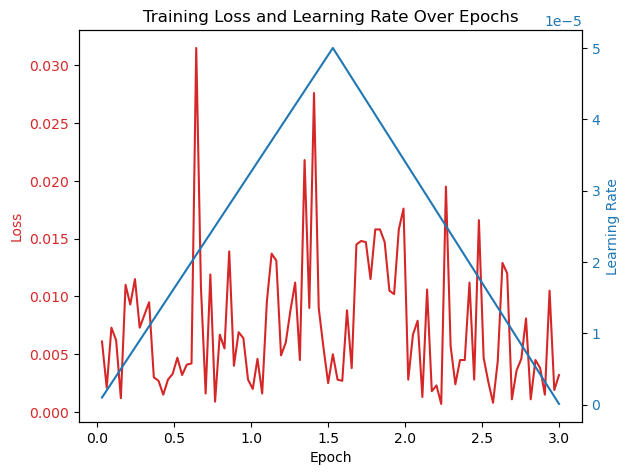

In [11]:
import matplotlib.pyplot as plt
def plot_learning_curves(log_history):
    epochs = [entry['epoch'] for entry in log_history if 'loss' in entry]
    losses = [entry['loss'] for entry in log_history if 'loss' in entry]
    learning_rates = [entry['learning_rate'] for entry in log_history if 'learning_rate' in entry]
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, losses, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Learning Rate', color='tab:blue')
    ax2.plot(epochs, learning_rates, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()  
    plt.title('Training Loss and Learning Rate Over Epochs')
    plt.show()
trainer.train()
plot_learning_curves(trainer.state.log_history)


In [21]:
from transformers import BertTokenizerFast, BertForTokenClassification, BertConfig
import torch
from datasets import load_dataset
from scipy.spatial.distance import cosine
import numpy as np

config = BertConfig.from_pretrained('./saved_model', output_hidden_states=True)
model = BertForTokenClassification.from_pretrained('./saved_model', config=config)
tokenizer = BertTokenizerFast.from_pretrained('./saved_model')
ner_dataset = load_dataset("tner/bc5cdr", split='validation')

# Select a query entity, disease with label 2
query_sample = next(sample for sample in ner_dataset if 2 in sample['tags'])
query_text = " ".join(query_sample['tokens'])  
query_tokens = tokenizer(query_text, return_tensors='pt', padding=True, truncation=True, max_length=128)

with torch.no_grad():
    outputs = model(**query_tokens)
    query_features = outputs.hidden_states[-1].squeeze(0).mean(dim=0)  

similarities = []
for sample in ner_dataset:
    text = " ".join(sample['tokens'])
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**tokens)
        features = outputs.hidden_states[-1].squeeze(0).mean(dim=0)
    
    sim = 1 - cosine(query_features.numpy(), features.numpy())
    similarities.append((text, sim))

similarities.sort(key=lambda x: x[1], reverse=True)
most_similar = similarities[:5]
least_similar = similarities[-5:]

print("Most Similar:", most_similar)
print("Least Similar:", least_similar)


Most Similar: [('Tricuspid valve regurgitation and lithium carbonate toxicity in a newborn infant .', 0.9999999776481341), ('Hepatic adenomas and focal nodular hyperplasia of the liver in young women on oral contraceptives : case reports .', 0.9865896069151816), ('Thromboembolic and other complications of oral contraceptive therapy in relationship to pretreatment levels of blood coagulation factors : summary report of a ten - year study .', 0.9863304481784113), ('Magnetic resonance imaging of cerebral venous thrombosis secondary to " low - dose " birth control pills .', 0.9862269932056816), ('Two cases of hepatic adenoma and one of focal nodular hyperplasia presumably associated with the use of oral contraceptives , are reported .', 0.9861266514475562)]
Least Similar: [("The therapeutic use of selective DA D1 receptor agonists such as SKF-82958 ( 6-chloro-7,8-dihydroxy-3-allyl-1-phenyl-2,3,4,5-tetrahydro-1H-3-benzaze pine hydrobromide ) and A-77636 ( [1R, 3S] 3-[1'-admantyl]-1-aminomet

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

texts = [" ".join(sample['tokens']) for sample in ner_dataset]

# TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

query_text = " ".join(query_sample['tokens'])
query_index = texts.index(query_text)  

cosine_similarities = cosine_similarity(tfidf_matrix[query_index:query_index+1], tfidf_matrix)

similarities = [(text, score) for score, text in zip(cosine_similarities[0], texts)]
similarities.sort(key=lambda x: x[1], reverse=True)

most_similar_tfidf = similarities[1:6]  
least_similar_tfidf = similarities[-5:]

print("TF-IDF Most Similar:", most_similar_tfidf)
print("TF-IDF Least Similar:", least_similar_tfidf)


TF-IDF Most Similar: [('A newborn with massive tricuspid regurgitation , atrial flutter , congestive heart failure , and a high serum lithium level is described .', 0.42151445359992584), ('Sixty - three percent of these infants had tricuspid valve involvement .', 0.3141576567343447), ('One had baseline bicuspid aortic valve and mild aortic regurgitation that progressed to moderate regurgitation .', 0.303565871855606), ('Lithium', 0.2729199180089674), ('This is the first patient to initially manifest tricuspid regurgitation and atrial flutter , and the 11th described patient with cardiac disease among infants exposed to lithium compounds in the first trimester of pregnancy .', 0.23148567631777142)]
TF-IDF Least Similar: [('2 %) developed iridocyclitis .', 0.0), ('However , 30 % of the patients developed uveitis after 16 years of age .', 0.0), ('Although 61 % of patients had a noncontributory ocular history on entry , 42 % had active uveitis on entry .', 0.0), ('Water intoxication associ